Decision Tree with LDA, t-SNE and UMAP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from google.colab import files
from sklearn.neighbors import NearestNeighbors
import os
import umap
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Check for GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [3]:
print(os.listdir("/content/"))

['.config', 'X_features.npy', 'X_lda.npy', 'y_labels.npy', 'sample_data']


In [6]:
# Load extracted features
X_features = np.load("/content/X_features.npy")
X_lda = np.load("/content/X_lda.npy")
y = np.load("/content/y_labels.npy")
print(f"Feature Shape: \n X_features: {X_features.shape} \n X_lda {X_lda.shape} \n Labels Shape: {y.shape}")

Feature Shape: 
 X_features: (2511, 4000) 
 X_lda (2511, 49) 
 Labels Shape: (2511,)


In [8]:
# Doing feature selection! (Threshold variance)
# keeping top 30 most relevant features

selector = SelectKBest(score_func=f_classif, k=30)
X_selected = selector.fit_transform(X_features, y)

print("Original feature shape:", X_features.shape)
print("Reduced feature shape:", X_selected.shape)

Original feature shape: (2511, 4000)
Reduced feature shape: (2511, 30)


In [10]:
# Convert to Torch Tensor and Move to GPU
X_tensor = torch.tensor(X_selected, dtype=torch.float32).to(device)

In [14]:
# Split data into Train (70%), Validation (15%), and Test (15%)
# Below is the code (commented out) when using Feature selection
# X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

X_train_feat, X_temp_feat, y_train_feat, y_temp_feat = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)
X_val_feat, X_test_feat, y_val_feat, y_test_feat = train_test_split(X_temp_feat, y_temp_feat, test_size=0.5, random_state=42, stratify=y_temp_feat)

X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Train Set: (1757, 49), Validation Set: (377, 49), Test Set: (377, 49)


In [15]:
# normalize dataset before dimensionality reduction.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

scaler_feat = StandardScaler()
X_train_feat_scaled = scaler_feat.fit_transform(X_train_feat)
X_val_feat_scaled = scaler_feat.transform(X_val_feat)
X_test_feat_scaled = scaler_feat.transform(X_test_feat)

# Apply dimensionality reduction
tsne_3d = TSNE(
    n_components=3,
    perplexity=40,
    n_iter=1000,
    random_state=42
)  # t-SNE with 3D output
umap_3d = umap.UMAP(n_components=3, random_state=42)  # UMAP with 3D output

# Fit t-SNE only on training data
X_train_tsne = tsne_3d.fit_transform(X_train_scaled)

# Instead of fitting separately, map validation/test using nearest neighbors
nbrs = NearestNeighbors(n_neighbors=10).fit(X_train_scaled)
X_val_tsne = tsne_3d.fit_transform(nbrs.kneighbors(X_val_scaled, return_distance=False))
X_test_tsne = tsne_3d.fit_transform(nbrs.kneighbors(X_test_scaled, return_distance=False))

# Fit UMAP on training data and use `.transform()` for val & test
X_train_umap = umap_3d.fit(X_train_scaled).transform(X_train_scaled)
X_val_umap = umap_3d.transform(X_val_scaled)
X_test_umap = umap_3d.transform(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

In [24]:
# Applyting t-SNE and UMAP on raw features
nbrs_feat = NearestNeighbors(n_neighbors=10).fit(X_train_feat_scaled)

# t-SNE on raw features
tsne_3d_feat = TSNE(n_components=3, perplexity=40, n_iter=1000, random_state=42)
X_train_tsne_feat = tsne_3d_feat.fit_transform(X_train_feat_scaled)
X_val_tsne_feat = tsne_3d_feat.fit_transform(nbrs_feat.kneighbors(X_val_feat_scaled, return_distance=False))
X_test_tsne_feat = tsne_3d_feat.fit_transform(nbrs_feat.kneighbors(X_test_feat_scaled, return_distance=False))

# UMAP on raw features
umap_3d_feat = umap.UMAP(n_components=3, random_state=42)
X_train_umap_feat = umap_3d_feat.fit_transform(X_train_feat_scaled)
X_val_umap_feat = umap_3d_feat.transform(X_val_feat_scaled)
X_test_umap_feat = umap_3d_feat.transform(X_test_feat_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

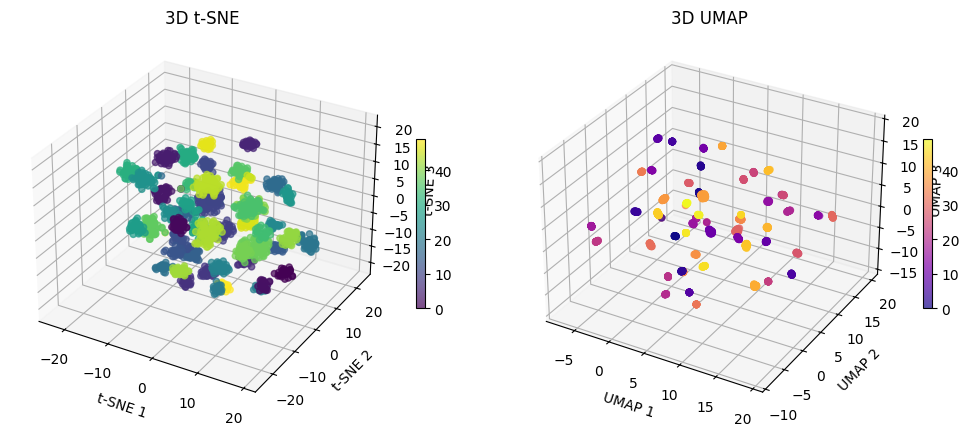

In [16]:
# 3D Plot of t-SNE and UMAP
fig = plt.figure(figsize=(12, 5))

# t-SNE Plot
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], c=y_train, cmap='viridis', alpha=0.7)
ax1.set_title("3D t-SNE")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.set_zlabel("t-SNE 3")
plt.colorbar(sc1, ax=ax1, fraction=0.02)

# UMAP Plot
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(X_train_umap[:, 0], X_train_umap[:, 1], X_train_umap[:, 2], c=y_train, cmap='plasma', alpha=0.7)
ax2.set_title("3D UMAP")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
ax2.set_zlabel("UMAP 3")
plt.colorbar(sc2, ax=ax2, fraction=0.02)

plt.show()

In [17]:
# --- Train Decision Tree from Scratch ---
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  #leaf node stores class label

# Calculate Gini Impurity
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs**2)

def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-9))  # Small value to avoid log(0)


# Split dataset
def split(X, y, feature, threshold):
    left_mask = X[:, feature] <= threshold
    right_mask = ~left_mask
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]


# Find best split (entropy is used instead of gini impurity)
def best_split(X, y):
    best_entropy = float('inf')  # We minimize entropy, so start with high value
    best_feature = None
    best_threshold = None

    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split(X, y, feature, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            # Weighted Entropy
            entropy_split = (len(y_left) / len(y)) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right)

            if entropy_split < best_entropy:
                best_entropy = entropy_split
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

In [18]:
# Build decision tree (modified)
def build_tree(X, y, depth=0, max_depth=None, min_samples_split=2, min_samples_leaf=1):
    if len(np.unique(y)) == 1:
        return Node(value=np.unique(y)[0])  # Pure node

    if max_depth is not None and depth >= max_depth:
        return Node(value=np.bincount(y).argmax())  # Return majority class

    if len(y) < min_samples_split:  # Stop if not enough samples
        return Node(value=np.bincount(y).argmax())

    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())  # No valid split

    X_left, y_left, X_right, y_right = split(X, y, feature, threshold)

    if len(y_left) < min_samples_leaf or len(y_right) < min_samples_leaf:
        return Node(value=np.bincount(y).argmax())  # Avoid splitting if leaf is too small

    return Node(
        feature=feature,
        threshold=threshold,
        left=build_tree(X_left, y_left, depth + 1, max_depth, min_samples_split, min_samples_leaf),
        right=build_tree(X_right, y_right, depth + 1, max_depth, min_samples_split, min_samples_leaf),
    )


# Prediction function
def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

# Apply prediction
def predict(model, X):
    return np.array([predict_tree(model, x) for x in X])

Method: t-SNE (LDA), Max Depth: 3, Avg Cross-Val Accuracy: 0.2464
Method: t-SNE (LDA), Max Depth: 5, Avg Cross-Val Accuracy: 0.6790
Method: t-SNE (LDA), Max Depth: 7, Avg Cross-Val Accuracy: 0.9442
Method: t-SNE (LDA), Max Depth: 10, Avg Cross-Val Accuracy: 0.9425
Method: t-SNE (LDA), Max Depth: 15, Avg Cross-Val Accuracy: 0.9425
Method: t-SNE (LDA), Max Depth: 20, Avg Cross-Val Accuracy: 0.9425
Method: t-SNE (LDA), Max Depth: 25, Avg Cross-Val Accuracy: 0.9425
Method: t-SNE (LDA), Max Depth: None, Avg Cross-Val Accuracy: 0.9425
Best Max Depth for t-SNE (LDA): 7 with Accuracy: 0.9442


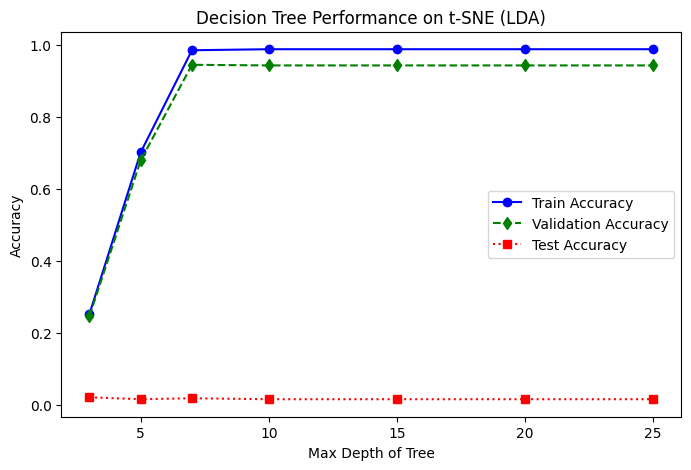

Method: UMAP (LDA), Max Depth: 3, Avg Cross-Val Accuracy: 0.2703
Method: UMAP (LDA), Max Depth: 5, Avg Cross-Val Accuracy: 0.7353
Method: UMAP (LDA), Max Depth: 7, Avg Cross-Val Accuracy: 0.9624
Method: UMAP (LDA), Max Depth: 10, Avg Cross-Val Accuracy: 0.9624
Method: UMAP (LDA), Max Depth: 15, Avg Cross-Val Accuracy: 0.9624
Method: UMAP (LDA), Max Depth: 20, Avg Cross-Val Accuracy: 0.9624
Method: UMAP (LDA), Max Depth: 25, Avg Cross-Val Accuracy: 0.9624
Method: UMAP (LDA), Max Depth: None, Avg Cross-Val Accuracy: 0.9624
Best Max Depth for UMAP (LDA): 7 with Accuracy: 0.9624


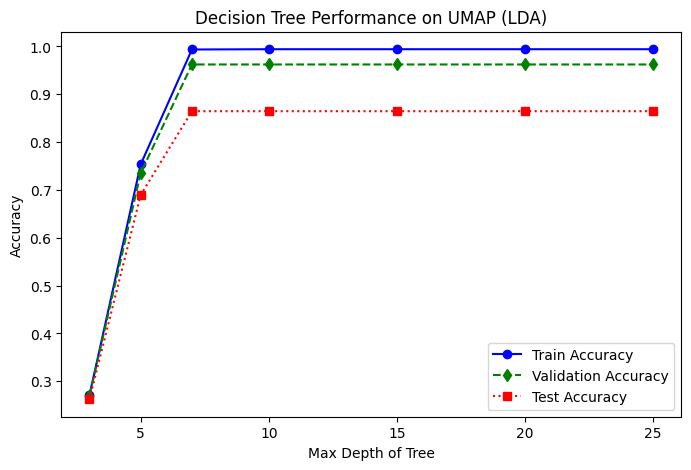

Method: t-SNE (Raw), Max Depth: 3, Avg Cross-Val Accuracy: 0.1053
Method: t-SNE (Raw), Max Depth: 5, Avg Cross-Val Accuracy: 0.1059
Method: t-SNE (Raw), Max Depth: 7, Avg Cross-Val Accuracy: 0.0984
Method: t-SNE (Raw), Max Depth: 10, Avg Cross-Val Accuracy: 0.0842
Method: t-SNE (Raw), Max Depth: 15, Avg Cross-Val Accuracy: 0.0774
Method: t-SNE (Raw), Max Depth: 20, Avg Cross-Val Accuracy: 0.0780
Method: t-SNE (Raw), Max Depth: 25, Avg Cross-Val Accuracy: 0.0780
Method: t-SNE (Raw), Max Depth: None, Avg Cross-Val Accuracy: 0.0780
Best Max Depth for t-SNE (Raw): 5 with Accuracy: 0.1059


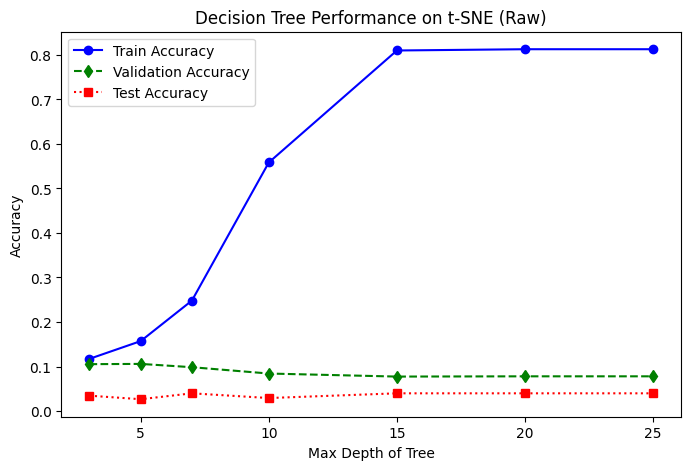

Method: UMAP (Raw), Max Depth: 3, Avg Cross-Val Accuracy: 0.0951
Method: UMAP (Raw), Max Depth: 5, Avg Cross-Val Accuracy: 0.1007
Method: UMAP (Raw), Max Depth: 7, Avg Cross-Val Accuracy: 0.0939
Method: UMAP (Raw), Max Depth: 10, Avg Cross-Val Accuracy: 0.0848
Method: UMAP (Raw), Max Depth: 15, Avg Cross-Val Accuracy: 0.0785
Method: UMAP (Raw), Max Depth: 20, Avg Cross-Val Accuracy: 0.0785
Method: UMAP (Raw), Max Depth: 25, Avg Cross-Val Accuracy: 0.0785
Method: UMAP (Raw), Max Depth: None, Avg Cross-Val Accuracy: 0.0785
Best Max Depth for UMAP (Raw): 5 with Accuracy: 0.1007


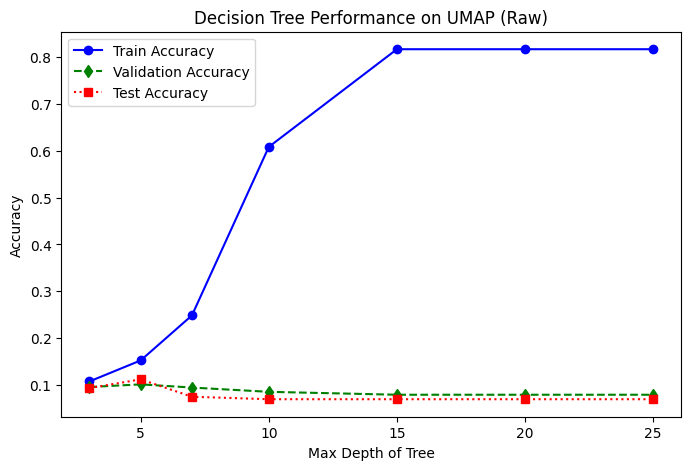

In [25]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy']
}

# Store results
results = {"t-SNE": [], "UMAP": []}

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop over both t-SNE and UMAP transformed datasets
for method, (X_train_transformed, X_val_transformed, X_test_transformed) in zip(
    ["t-SNE (LDA)", "UMAP (LDA)", "t-SNE (Raw)", "UMAP (Raw)"],
    [
        (X_train_tsne, X_val_tsne, X_test_tsne),
        (X_train_umap, X_val_umap, X_test_umap),
        (X_train_tsne_feat, X_val_tsne_feat, X_test_tsne_feat),
        (X_train_umap_feat, X_val_umap_feat, X_test_umap_feat)
    ]
):
    best_accuracy = 0
    best_params = None
    best_tree = None

    # Move lists outside max_depth loop
    train_accs = []
    val_accs = []
    test_accs = []

    depths = param_grid['max_depth']

    for max_depth in depths:
        fold_accuracies = []

        for train_idx, val_idx in kf.split(X_train_transformed, y_train):
            X_kfold_train, X_kfold_val = X_train_transformed[train_idx], X_train_transformed[val_idx]
            y_kfold_train, y_kfold_val = y_train[train_idx], y_train[val_idx]

            tree = build_tree(X_kfold_train, y_kfold_train, max_depth=max_depth)
            y_kfold_pred = predict(tree, X_kfold_val)

            fold_accuracies.append(np.mean(y_kfold_val == y_kfold_pred))

        avg_val_acc = np.mean(fold_accuracies)

        print(f"Method: {method}, Max Depth: {max_depth}, Avg Cross-Val Accuracy: {avg_val_acc:.4f}")

        if avg_val_acc > best_accuracy:
            best_accuracy = avg_val_acc
            best_params = max_depth

        # Append values after every depth check
        train_accs.append(np.mean(y_train == predict(tree, X_train_transformed)))
        val_accs.append(avg_val_acc)
        test_accs.append(np.mean(y_test == predict(tree, X_test_transformed)))

    print(f"Best Max Depth for {method}: {best_params} with Accuracy: {best_accuracy:.4f}")

    # Train the best model on full training data
    best_tree = build_tree(X_train_transformed, y_train, max_depth=best_params)

    # Store only the best result
    results[method] = (best_params, best_accuracy)

    # ✅ Ensure proper plotting
    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_accs, marker='o', linestyle='-', label="Train Accuracy", color='b')
    plt.plot(depths, val_accs, marker='d', linestyle='--', label="Validation Accuracy", color='g')
    plt.plot(depths, test_accs, marker='s', linestyle=':', label="Test Accuracy", color='r')

    plt.xlabel("Max Depth of Tree")
    plt.ylabel("Accuracy")
    plt.title(f"Decision Tree Performance on {method}")
    plt.legend()
    plt.show()

In [20]:
# Decision Tree on X_features (without LDA)
best_tree_feat = build_tree(X_train_feat_scaled, y_train_feat, max_depth=best_params)

# Get test accuracy for X_features
feat_test_acc = np.mean(y_test_feat == predict(best_tree_feat, X_test_feat_scaled))

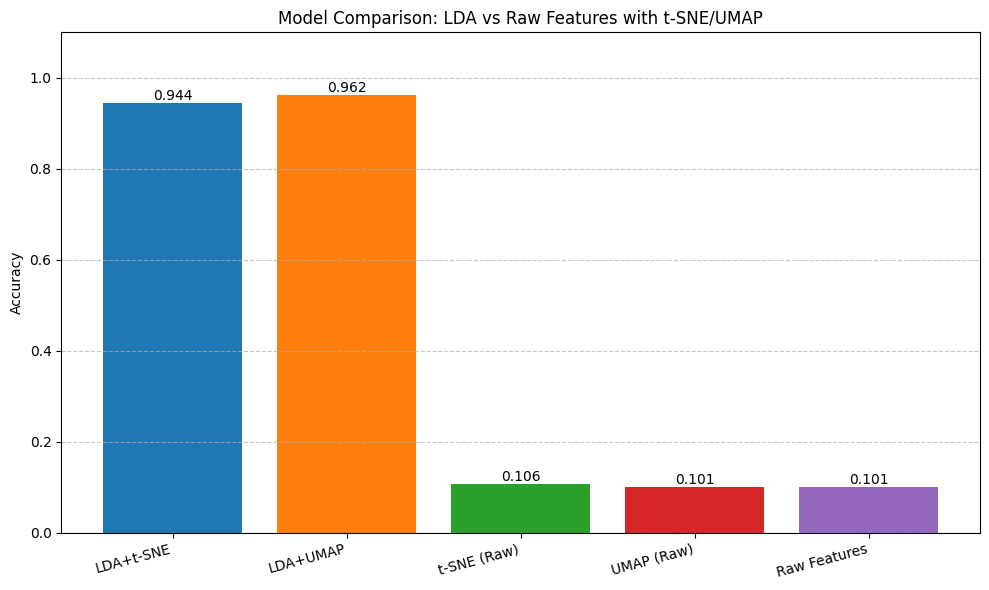

In [27]:
# Final comparison of methods
methods = ['LDA+t-SNE', 'LDA+UMAP', 't-SNE (Raw)', 'UMAP (Raw)', 'Raw Features']
accuracies = [
    results["t-SNE (LDA)"][1],
    results["UMAP (LDA)"][1],
    results["t-SNE (Raw)"][1],
    results["UMAP (Raw)"][1],
    feat_test_acc
]

plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bars = plt.bar(methods, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Model Comparison: LDA vs Raw Features with t-SNE/UMAP')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# X-axis labels rotated for better readability
plt.xticks(rotation=15, ha='right')

# Accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}',
             ha='center', va='bottom')

plt.tight_layout()  # Layout adjusted to prevent label cutoff
plt.show()